In [ ]:
!pip install openai > NULL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import openai
import numpy as np
import pandas as pd
import seaborn as sns
from openai import OpenAI
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

Reading data

In [ ]:
df_x = pd.read_csv('./drive/MyDrive/proj/interview.data/interview.X.csv')
df_y = pd.read_csv('./drive/MyDrive/proj/interview.data/interview.y.csv')

Data correlation plot

<ipython-input-5-45ad4f906809>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_x.corr())


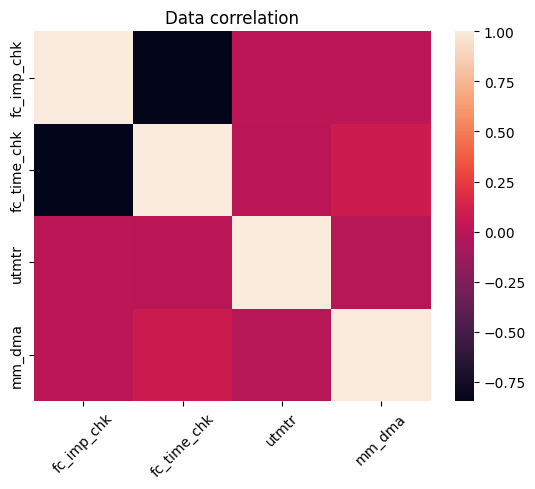

In [ ]:
sns.heatmap(df_x.corr())
plt.xticks(rotation=45)
plt.title("Data correlation")
plt.show()

Dropping repeated data samples by `uid`

In [ ]:
# dropping duplicates
df_x.drop_duplicates(subset=['uid'], inplace=True)
df_y.drop_duplicates(subset=['uid'], inplace=True)

df_x.reset_index(inplace=True, drop=True)
df_y.reset_index(inplace=True, drop=True)


Merging two similar columns

In [ ]:
# `mobile+phone` replaced with `mobile phone`
df_x.hardware.replace('Mobile+Phone', 'Mobile Phone', inplace=True)

Getting frequency of `osName`, `model` and `hardware` for handling NaN points

In [ ]:
d_model = {}
d_os = {}
d_hardware = {}

def most_repeated(strings):
    string_counts = Counter(strings)
    most_repeated = string_counts.most_common(1)
    if most_repeated:
        return most_repeated[0][0]
    else:
        return None

for mod in tqdm(df_x.model.unique()):
    curr_os = list(df_x[df_x.model==mod].loc[:, ['osName']].values[:, 0])
    curr_hard = list(df_x[df_x.model==mod].loc[:, ['hardware']].values[:, 0])
    d_model[mod] = [most_repeated(curr_os), most_repeated(curr_hard)]

for mod in tqdm(df_x.osName.unique()):
    curr_model = list(df_x[df_x.osName==mod].loc[:, ['model']].values[:, 0])
    curr_hard = list(df_x[df_x.osName==mod].loc[:, ['hardware']].values[:, 0])
    d_os[mod] = [most_repeated(curr_model), most_repeated(curr_hard)]

for mod in tqdm(df_x.hardware.unique()):
    curr_model = list(df_x[df_x.hardware==mod].loc[:, ['model']].values[:, 0])
    curr_os = list(df_x[df_x.hardware==mod].loc[:, ['osName']].values[:, 0])
    d_hardware[mod] = [most_repeated(curr_model), most_repeated(curr_os)]

In [ ]:
if not os.path.isfile('./drive/MyDrive/proj/d_model.json'):
  with open('./drive/MyDrive/proj/d_model.json', 'w') as f:
    json.dump(d_model, f)
else:
  with open('./drive/MyDrive/proj/d_model.json', 'r') as f:
    d_model = json.load(f)

if not os.path.isfile('./drive/MyDrive/proj/d_os.json'):
  with open('./drive/MyDrive/proj/d_os.json', 'w') as f:
    json.dump(d_os, f)
else:
  with open('./drive/MyDrive/proj/d_os.json', 'r') as f:
    d_os = json.load(f)

if not os.path.isfile('./drive/MyDrive/proj/d_hardware.json'):
  with open('./drive/MyDrive/proj/d_hardware.json', 'w') as f:
    json.dump(d_hardware, f)
else:
  with open('./drive/MyDrive/proj/d_hardware.json', 'r') as f:
    d_hardware = json.load(f)

Handling NaNs

In [ ]:
def searchBy(indicator, nanID):
    if not nanID[1]:
        if sum(nanID) == 2:
            indicator[0] = d_model[indicator[1]][0]
            indicator[2] = d_model[indicator[1]][1]
        elif sum(nanID) == 1:
            modifiedID = nanID[::2]
            indicator[nanID] = np.array(d_model[indicator[1]])[modifiedID]
        else:
            print('SKIP')

    elif not nanID[0]:
        if sum(nanID) == 2:
            indicator[1] = d_os[indicator[0]][0]
            indicator[2] = d_os[indicator[0]][1]
        elif sum(nanID) == 1:
            modifiedID = nanID[1:]
            indicator[nanID] = np.array(d_os[indicator[0]])[modifiedID]
        else:
            print('SKIP')

    elif not nanID[2]:
        if sum(nanID) == 2:
            indicator[0] = d_hardware[indicator[2]][1]
            indicator[1] = d_hardware[indicator[2]][0]
        else:
            print('SKIP')


    return indicator

new_df = df_x.copy()
for i, characteristics in enumerate(tqdm(df_x.loc[:, ['osName', 'model', 'hardware']].values)):
    nan_list = list(map(pd.isna, characteristics))

    if sum(nan_list) == 3 or sum(nan_list) == 0:
      continue
    else:
        new_df.loc[i, ['osName', 'model', 'hardware']] = searchBy(characteristics, nan_list)


  0%|          | 0/954978 [00:00<?, ?it/s]

In [ ]:
print(f'Before handling NaN counts: {df_x.isna().sum().sum()}')
print(f'After handling NaN counts: {new_df.isna().sum().sum()}')

Before handling NaN counts: 24472
After handling NaN counts: 23667


Drop NaN points which can’t be handled

In [ ]:
new_df.dropna(inplace=True)
new_df.reset_index(inplace=True, drop=True)

Converting `reg_time`column to numerical representation and normalizing other numerical columns.

In [ ]:
new_df['reg_time'] = pd.to_datetime(new_df['reg_time'])

# Set the reference date and time
reference_date = pd.to_datetime('1970-01-20 00:00:00')
new_df['reg_time'] = (new_df['reg_time'] - reference_date).dt.total_seconds()

scaler = MinMaxScaler()
new_df['reg_time'] = scaler.fit_transform(new_df[['reg_time']])
new_df['fc_imp_chk'] = scaler.fit_transform(new_df[['fc_imp_chk']])
new_df['fc_time_chk'] = scaler.fit_transform(new_df[['fc_time_chk']])
new_df['utmtr'] = scaler.fit_transform(new_df[['utmtr']])
new_df['mm_dma'] = scaler.fit_transform(new_df[['mm_dma']])

One-hot encoding of categorical columns

In [ ]:
#categorical data
categorical_cols = ['osName', 'model', 'hardware']

#import pandas as pd
df = pd.get_dummies(new_df, columns = categorical_cols, drop_first=True)

Get embeddings of `site_id`

In [ ]:
def get_embedding(text, client, model="text-embedding-ada-002"):
    return client.embeddings.create(input=[text], model=model).data[0].embedding

def embed_column(df, column_name):
    if os.path.isfile('./drive/MyDrive/proj/embeddings.json'):
      with open('./drive/MyDrive/proj/embeddings.json', 'r') as f:
        embeddings = json.load(f)
    else:
      api_key = 'your-api-key'
      client = OpenAI(api_key=api_key)
      embeddings = {}
      for text in tqdm(df[column_name].unique()):
          embedding = get_embedding(text, client)
          embeddings[text] = embedding
      with open('./drive/MyDrive/proj/embeddings.json', 'w') as f:
          json.dump(embeddings, f)
    return embeddings

text_column_name = 'site_id'
embeddings = embed_column(df, text_column_name)

Converting data to corresponding type and saving

In [ ]:
data_X = []
data_Y = []

col =  df.columns.delete([1, 6])

for uID in tqdm(df.uid):
  if sum(uID == df_y.uid):
    curr_point = df.loc[df.uid == uID, :]
    emb = embeddings[curr_point.site_id.values[0]]
    feature = np.concatenate([curr_point.loc[:, col].to_numpy().astype(np.float32), np.array(emb)[None]], axis=-1)
    lbl = 0. if df_y[df_y.uid == uID].tag.values[0].startswith('v') else 1.

    data_X.append(feature)
    data_Y.append(lbl)

np.save('./drive/MyDrive/proj/data_norm_X.npy', np.squeeze(np.array(data_X)))
np.save('./drive/MyDrive/proj/data_norm_Y.npy', np.squeeze(np.array(data_Y)))
